# Imports

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
from sklearn.preprocessing import StandardScaler
import wfdb

# Helper functions

In [2]:
# function to read multiple records
import os
def rec_list(dir_name):
    file_rec = os.listdir(dir_name)
    file_list=[]
    for f in file_rec:
        if f.endswith('.atr'):
            str_f_name=f.split('.')[0]
            file_list+=[dir_name+'/'+str_f_name]
    return file_list
#dir_name= 'european-st-t-database'

In [3]:
# function to read records
def read_rec(f_name):
    record = wfdb.rdrecord(f_name)
    print(record.sig_name)
    if 'V4' in record.sig_name:
        #wfdb.plot_wfdb(record=record, title=f_name) #plot ecg
        #print("Reading "+f_name)
        #display(record.__dict__) # display details if record
        return record
    else:
        return {}

In [4]:
# function to scale the data availble
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()#standard scaler did not fit our use
def scale_input_data(record):
    #we shift the data with mean so that it becomes zero
    arr1=np.array(record.p_signal[:])
    x, y = arr1.T
    if record.sig_name[0]=='V4':
        x-=np.mean(x)
        scaledX=x.reshape(-1,1)
    else:
        y-=np.mean(y)
        scaledX=y.reshape(-1,1)
    return(scaledX)

In [5]:
# function to get r point
import numpy as np
def get_r_point_of_rec(scaledX):
    ts=[y for y in range(len(scaledX))]
    x=scaledX
    r_point_array = []
    start_index = 0
    while (start_index < len(scaledX)):
        if start_index == 0:
            ts=np.array([u+1 for u in range(200)])
            sample=x[:200]
            r_point_y=max(sample)
            point=np.where(sample == max(sample))[0][0]
            r_point_x=ts[point]
            #print(r_point_y)
            r_point_array+=[r_point_x]
            start_index=int(r_point_x)+40
        else:
            ts=np.array([u+1 for u in range(200)])

            sample=sample.reshape(1,-1)[0]
            next_i=0
            #print(sample)
            if (start_index+next_i)<len(scaledX):
                while (start_index+next_i)<len(scaledX) and (x[start_index+next_i]<0.23 or (x[next_i]<x[next_i+1])):
                    next_i+=1
                '''
                while (start_index+next_i)<record.sig_len and x[next_i]<x[next_i+1]:
                    next_i+=1
                '''
                r_point_array+=[start_index+next_i] 
            # next we find the slope made by the line connecting to the s point
            start_index=start_index+next_i+40
    return(r_point_array)

In [6]:
# function to get qrs angles
import math
def get_qrs_angles(scaledX,r_point_array):
    ts=[y for y in range(len(scaledX))]
    x=scaledX
    qrs_angle_list=[]
    for r_point_x in r_point_array:
        if r_point_x<len(scaledX):
            r_point_y=x[r_point_x]
            # next we find the slope made by the line connecting to the s point
            d=50
            if r_point_x+50>len(scaledX):
                d=len(scaledX)-r_point_x
            for j in range(r_point_x,r_point_x+d-1):
                if x[j]<x[j+1] and x[j]<0:
                    break
            for k in range(r_point_x,r_point_x-50,-1):
                if x[k-1]>x[k] and x[j]<0.5:
                    break
            q_point_y=x[k][0]
            q_point_x=k
            s_point_y=x[j][0]
            s_point_x=j
            #print(q_point_x,q_point_y,r_point_x,r_point_y,s_point_x,s_point_y)
            rs_slope=((s_point_y-r_point_y)/(s_point_x-r_point_x))
            qr_slope=((r_point_y-q_point_y)/(r_point_x-q_point_x))
            qrs_angle_list+=[180-(math.degrees(math.atan(qr_slope))+(180+(math.degrees(math.atan(rs_slope)))))]
    return(qrs_angle_list)

In [7]:
# function to get qrs area
def get_qrs_area(scaledX,r_point_array):
    ts=[y for y in range(len(scaledX))]
    x=scaledX
    qrs_area_list=[]
    for r_point_x in r_point_array:
        if r_point_x<len(scaledX):
            r_point_y=x[r_point_x][0]
            # next we find the slope made by the line connecting to the s point
            d=50
            if r_point_x+50>len(scaledX):
                d=len(scaledX)-r_point_x
            for j in range(r_point_x,r_point_x+d-1):
                if x[j]<x[j+1] and x[j]<0:
                    break
            for k in range(r_point_x,r_point_x-50,-1):
                if x[k-1]>x[k] and x[j]<0.5:
                    break
            q_point_y=x[k][0]
            q_point_x=k
            s_point_y=x[j][0]
            s_point_x=j
            #print(q_point_x,q_point_y,r_point_x,r_point_y,s_point_x,s_point_y)
            area_tri=0.5*((r_point_x*(q_point_y-s_point_y))+(q_point_x*(s_point_y-r_point_y))+(s_point_x*(r_point_y-q_point_y)))
            qrs_area_list+=[abs(area_tri)]
    return(qrs_area_list)

# Running on single record

In [8]:
recordy=read_rec('european-st-t-database/e0103')
scaleddata=scale_input_data(recordy)
r_points=get_r_point_of_rec(scaleddata)
qrs_angles=get_qrs_angles(scaleddata,r_points)
qrs_areas=get_qrs_area(scaleddata,r_points)
print(np.nanmean(qrs_angles),np.nanstd(qrs_angles))
print(np.nanmean(qrs_areas),np.nanstd(qrs_areas))

['V4', 'MLIII']


e:\python\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


-3.7688589507084864 3.695929957181622
6.5550807430789995 4.243679454543793


In [9]:
print(r_points)

[51, 265, 497, 563, 749, 814, 998, 1252, 1316, 1494, 1557, 1754, 1817, 2013, 2260, 2324, 2499, 2565, 2740, 2802, 2980, 3042, 3220, 3282, 3465, 3529, 3716, 3954, 4010, 4190, 4250, 4434, 4498, 4674, 4739, 4921, 4986, 5178, 5243, 5439, 5699, 5952, 6208, 6273, 6471, 6727, 6987, 7256, 7321, 7518, 7585, 7777, 7842, 8029, 8095, 8295, 8359, 8568, 8633, 8835, 8898, 9090, 9154, 9352, 9417, 9623, 9685, 9885, 9952, 10136, 10392, 10645, 10705, 10897, 10957, 11150, 11217, 11409, 11474, 11667, 11733, 11931, 11994, 12186, 12246, 12450, 12516, 12718, 12786, 12985, 13254, 13523, 13783, 14041, 14106, 14286, 14546, 14614, 14810, 14876, 15078, 15347, 15411, 15597, 15659, 15837, 15902, 16094, 16160, 16356, 16418, 16623, 16688, 16881, 16949, 17141, 17206, 17398, 17463, 17656, 17721, 17908, 18161, 18227, 18413, 18666, 18919, 18984, 19164, 19408, 19473, 19655, 19720, 19912, 20165, 20225, 20405, 20473, 20655, 20722, 20909, 20974, 21160, 21225, 21409, 21662, 21729, 21921, 21986, 22172, 22430, 22688, 22943, 23187

In [10]:
print(qrs_angles)

[nan, -1.7042989271154738, -5.188007430129744, -0.039381193819707505, -8.960662653031989, 0.04235214493914441, -4.1922971292929105, -6.981702928320374, -0.06592880529800027, -5.651851242246522, -0.16476850142069566, -2.445412350502977, -0.29267651298863484, -7.302909132250676, -7.760306312484516, -0.010830470992743813, -1.8349308398834125, 0.13818387116094755, -11.256418538711614, -0.5950937193931054, -3.3735637802385554, -0.4693488731131197, -6.813529499916314, -0.12559303929364773, -7.131465133014785, -0.031824090125468274, -1.2200212003321838, -0.828135122844003, nan, -4.057285954918655, -0.13955384234736812, -4.986815856859096, 0.00272783397693388, -6.105534951055887, 0.1584945674510152, -4.918381240326767, 0.24908168679195342, -7.568956324848642, -0.10798180355166664, -7.768520203879717, -5.1431687340844405, -3.115403440483192, -7.374260250809186, 0.04415370185151346, -7.3232941398978255, -6.741674349013039, -5.97112227846381, -6.423218736725204, -0.05155871162975245, -2.906138278

In [11]:
print(qrs_areas)

[0.0, 6.644999999999996, 2.644999999999996, 3.7575000000000074, 10.064999999999998, 5.94250000000001, 5.617500000000007, 3.2475000000000023, 5.409999999999997, 4.024999999999977, 3.9399999999999977, 6.274999999999977, 3.6725000000000136, 9.857500000000073, 3.7825000000000273, 3.8024999999999523, 5.637499999999932, 5.002499999999941, 11.185000000000173, 4.147500000000036, 4.459999999999923, 2.3100000000000023, 8.652499999999918, 9.044999999999959, 7.6375000000000455, 1.0600000000000165, 8.375, 12.440000000000055, 0.0, 10.307500000000118, 8.93999999999994, 8.720000000000027, 4.417500000000018, 2.7924999999999045, 9.162499999999909, 5.150000000000091, 5.4424999999999955, 3.5125000000000455, 5.36749999999995, 10.712500000000546, 5.310000000000173, 17.289999999999964, 7.129999999999654, 6.404999999999973, 7.315000000000055, 5.154999999999745, 4.255000000000109, 4.740000000000009, 6.627500000000055, 4.0125000000000455, 8.309999999999945, 8.487500000001091, 7.519999999999982, 5.13750000000004

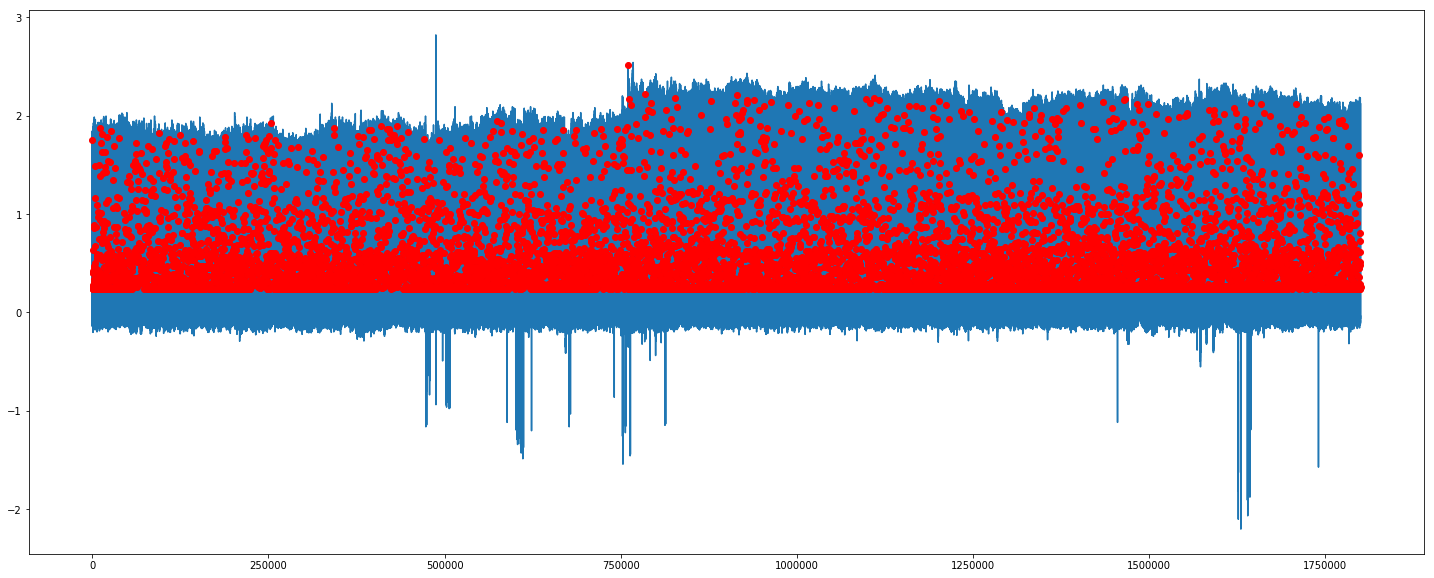

In [13]:
plt.rcParams["figure.figsize"] = (25,10)
ts=[y for y in range(len(scaleddata))]
plt.plot(ts,scaleddata)
for r in r_points:
    plt.plot(r,scaleddata[r], '-o',color="red")
plt.show()

# Running on multiple records

In [ ]:
file_rec_list=rec_list('european-st-t-database')
recordi={}
for entry in file_rec_list:
    print("Stats for "+entry+":")
    recordi=read_rec(entry)
    #print(type(recordi))
    if type(recordi)!=type({}):
        scaled_data=scale_input_data(recordi)
        r_points=get_r_point_of_rec(scaled_data)
        #print(r_points)
        qrs_angles=get_qrs_angles(scaled_data,r_points)
        qrs_areas=get_qrs_area(scaled_data,r_points)
        print("Mean of QRS angles:",np.nanmean(qrs_angles),";"+"Std deviation of QRS angle:",np.nanstd(qrs_angles))
        print("Mean of QRS area:",np.nanmean(qrs_areas),";"+"Std deviation of QRS area:",np.nanstd(qrs_areas))